# Autor: Marcos Torres Vivanco
## Prueba Ciencia de Datos







# 1. ¿Qué pruebas identificarías para asegurar la calidad de estos datos?

Primero revisemos la calidad de la tabla que contiene los datos. Se debe identificar el tipo de dato de las columnas (texto, numéricos, fechas, etc.). Se tiene que hacer una revisión de los valores nulos (nan) que existan en la tabla, si se encuentran nan en filas que interfieran con los calculos deberán ser removidos o si es posible dado el contexto y tipo de dato, cambiarlos por otro valor (cero, etc.). También revisar si existen valores repetidos, para eliminar todas las duplicaciones. Se debe verificar que en la tabla exista una llave con la que se puede acceder de manera única a cada elemento de la tabla.

Debemos revisar la fecha de los datos, en la página de la FGJ se menciona que los datos son a partir de enero de 2016, por lo que cualquier dato con fecha anterior puede ser considerado un error.

Para verificar que se disponga de la suficiente información se debe identificar la cantidad de delitos diferentes que existen así como la cantidad de registros por tipo de delito.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from prophet import Prophet
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

ALCALDIAS = ['BENITO JUAREZ', 'IZTAPALAPA', 'CUAUHTEMOC', 'TLAHUAC',
       'IZTACALCO', 'GUSTAVO A MADERO', 'MIGUEL HIDALGO', 'TLALPAN',
       'ALVARO OBREGON', 'VENUSTIANO CARRANZA', 'AZCAPOTZALCO',
       'CUAJIMALPA DE MORELOS', 'COYOACAN', 'XOCHIMILCO',
       'LA MAGDALENA CONTRERAS', 'MILPA ALTA']

Importing plotly failed. Interactive plots will not work.


In [2]:
carpeta_completa = pd.read_csv('carpetas_completa_junio_2021.csv', parse_dates=[0])

# 2. Identifica los delitos que van a la alza y a la baja en la CDMX

Primero ordenamos los delitos por número de ocurrencias. Trabajaremos con los 50 delitos más frecuentes para evitar errores al usar delitos que casi no tienen información.

También obtenemos los datos de la cantidad de delitos, agregados por día y por tipo de delito. Las fechas en que se registran los delitos están a nivel hora, por lo que creamos una función para poder agruparlas a nivel diario.

Para evitar problemas con cualquier tipo de efecto de estacionalidad (por ejemplo que los delitos sean mayores en cierto periodo del año), la forma en que calcularemos el crecimiento de un delito será la siguiente:
- Determinamos el número de ocurrencias del delito en el periodo 1-jun-2020 al 1-jun-2021 (información más reciente)
- Determinamos el número de ocurrencias del delito en el periodo 1-jun-2019 al 1-jun-2020 (información del año inmediatamente anterior)
- Comparamos el porcentaje de crecimiento de un año al siguiente.

Calculamos este crecimiento para los 50 delitos con más información.

In [3]:
delitos_cantidad = carpeta_completa.groupby(['delito']).size()
print('Hay '+str(len(delitos_cantidad))+' delitos diferentes en la tabla.')
### obtenemos los delitos por ocurrencia y los ordenamos de mayor a menor
delitos_cantidad = delitos_cantidad.reset_index()
delitos_cantidad = delitos_cantidad.rename(columns={0:'ocurrencias'})
delitos_cantidad = delitos_cantidad.sort_values(by=['ocurrencias'], ascending=False)
delitos_cantidad = delitos_cantidad.reset_index(drop=True)
print(delitos_cantidad.head(10))

### agrupamos los delitos por fecha y por tipo de delito
delitos_fecha = carpeta_completa.groupby(['delito','fecha_hechos']).size()
delitos_fecha = pd.DataFrame(delitos_fecha).reset_index()
delitos_fecha = delitos_fecha.rename(columns={0:"ocurrencias"})
delitos_fecha["fecha_hechos"] = pd.to_datetime(delitos_fecha["fecha_hechos"]).dt.date

Hay 345 delitos diferentes en la tabla.
                                              delito  ocurrencias
0                                 VIOLENCIA FAMILIAR       129056
1                                             FRAUDE        76975
2                                    ROBO DE OBJETOS        72807
3                                           AMENAZAS        67458
4                       ROBO A NEGOCIO SIN VIOLENCIA        66809
5     ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA        61909
6                                 DENUNCIA DE HECHOS        40156
7                         ROBO DE ACCESORIOS DE AUTO        39709
8        ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO        34397
9  ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...        32204


In [4]:
## creamos funciones para agrupar los delitos a nivel diario y anual
def aggregate_by_day(original_data_frame, date_column):
    original_data_frame[date_column] = pd.to_datetime(original_data_frame[date_column])
    original_data_frame = original_data_frame.set_index(date_column)
    month_df = original_data_frame.resample("d").sum().reset_index(drop=False)
    return month_df

## creamos una función que filtra un tipo específico de delito
def get_df_specific(name_crime):
    especifico_df = delitos_fecha[delitos_fecha.delito == name_crime]
    especifico_df = aggregate_by_day(especifico_df,"fecha_hechos")
    reciente_df = especifico_df[especifico_df.fecha_hechos > '2018-01-01']
    return reciente_df
## obtenemos el crecimiento anual de los delitos comparando la cantidad de delitos cometidos en 2019
## contra la cantidad de delitos comentidos en 2020
def crecimiento_anual(nombre_crimen):
    df_specific = get_df_specific(nombre_crimen)
    df_diario = aggregate_by_day(df_specific, "fecha_hechos")
    df_recent = df_diario[(df_diario.fecha_hechos >= '2020-06-01') & (df_diario.fecha_hechos < '2021-06-01')]
    df_past = df_diario[(df_diario.fecha_hechos >= '2019-06-01') & (df_diario.fecha_hechos < '2020-06-01')]
    
    try:
        crime_recent = sum(df_recent.ocurrencias)
        crime_past = sum(df_past.ocurrencias)
        crecimiento = (crime_recent-crime_past)/crime_past
    except:
        crecimiento = 0
    return crecimiento

df_delitos_comunes = delitos_cantidad.iloc[:50]
delitos_comunes = list(df_delitos_comunes["delito"])

crecimiento_delitos = []
for delito in delitos_comunes:
    crecimiento = crecimiento_anual(delito)
    crecimiento_delitos.append(crecimiento)
df_delitos_comunes["crecimiento_anual"] = crecimiento_delitos
df_delitos_comunes = df_delitos_comunes.sort_values(by=['crecimiento_anual'], ascending=False)
df_delitos_comunes = df_delitos_comunes.reset_index(drop=True)

def plot_crime(crime_name):
    reciente_df = get_df_specific(crime_name)
    fig1=plt.figure(figsize=(10,4))
    plt.title(crime_name)
    plt.plot(reciente_df.fecha_hechos, reciente_df.ocurrencias)

Para apoyarnos con la visualización de los datos construimos una función que grafica los datos de un crimen en específico. De esta forma nos damos cuenta que los primeros dos delitos representan en la lista, tienen un crecimiento elevado pues son resultado de datos faltantes y los excluimos de nuestro análisis.

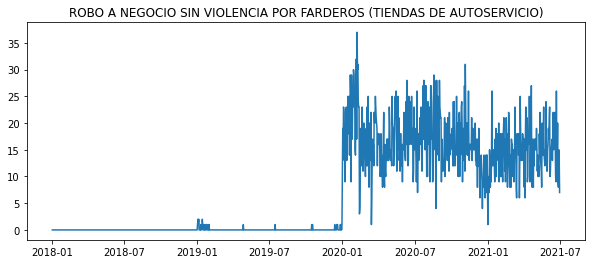

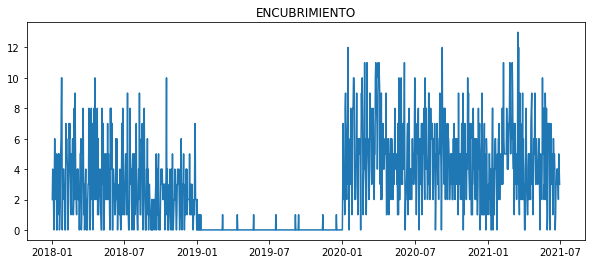

In [5]:
plot_crime(df_delitos_comunes['delito'].iloc[0])
plot_crime(df_delitos_comunes['delito'].iloc[1])

Los primeros 3 delitos que se encuentran a la alza son robo de vehículo de pedales, violencia familiar y perdida de la vida por otras causas.

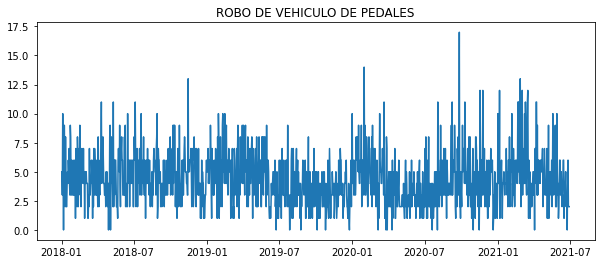

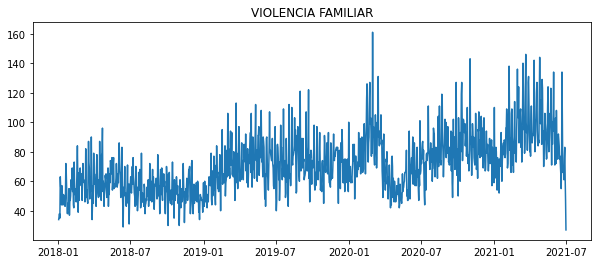

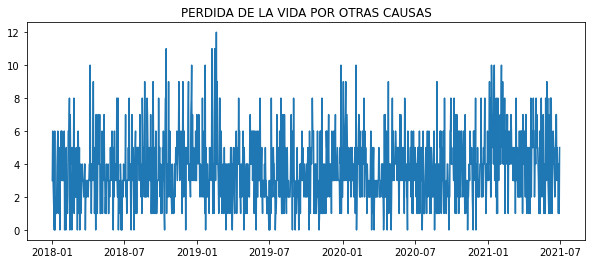

In [6]:
plot_crime(df_delitos_comunes['delito'].iloc[2])
plot_crime(df_delitos_comunes['delito'].iloc[3])
plot_crime(df_delitos_comunes['delito'].iloc[4])

Nuevamente hay delitos dentro de los que presentan más decrecimiento, pero es provocado por falta de información. 

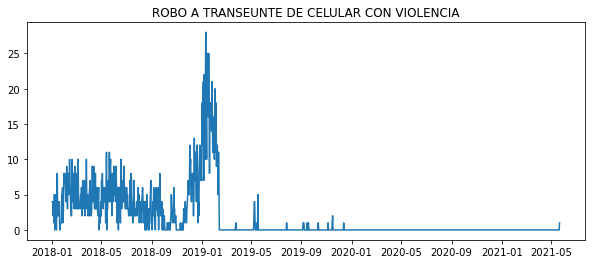

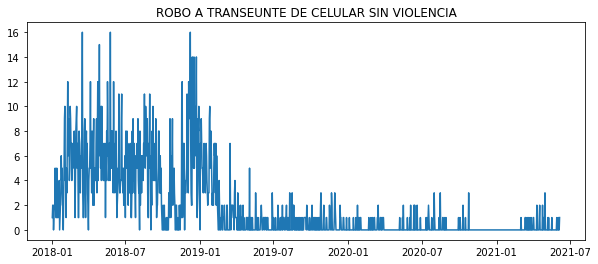

In [7]:
plot_crime(df_delitos_comunes['delito'].iloc[-1])
plot_crime(df_delitos_comunes['delito'].iloc[-4])

Los tres delitos con mayor decrecimiento son los siguientes.

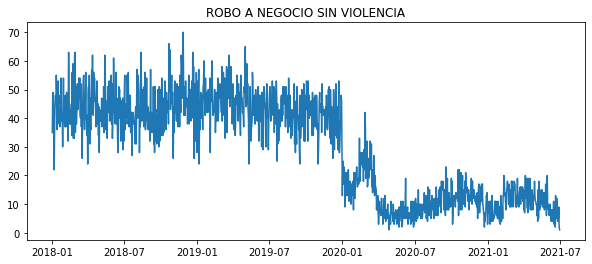

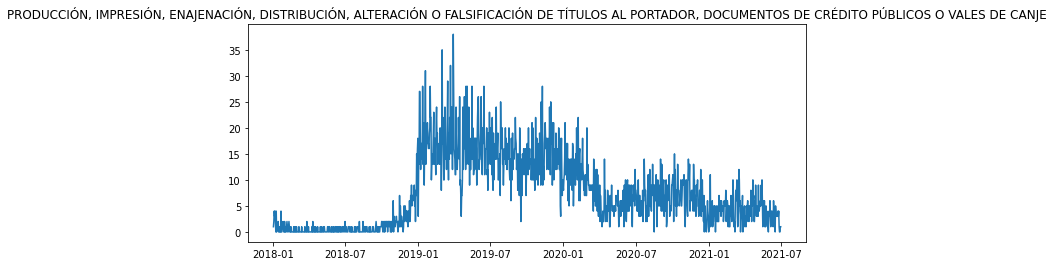

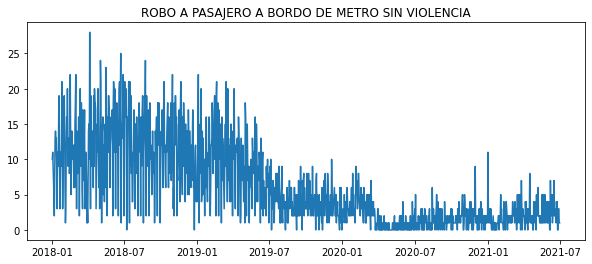

In [8]:
plot_crime(df_delitos_comunes['delito'].iloc[-2])
plot_crime(df_delitos_comunes['delito'].iloc[-3])
plot_crime(df_delitos_comunes['delito'].iloc[-5])

# 3. ¿Cuál es la alcaldía que más delitos tiene y cuál es la que menos?¿Por qué crees que sea esto?

Agrupamos la cantidad de ocurrencias de delitos por alcaldia, usando la información de los últimos 12 meses disponibles (es decir desde el 1-jun-2020 en adelante) y  filtramos sólo las 16 alcaldías de la CDMX en la base de datos.

Luego las ordenamos en orden dependiendo de la cantidad de delitos, podemos darnos cuenta de que la alcaldía con más delitos es Iztapalapa y la que tiene menos es Milpa Alta

In [9]:
ALCALDIAS = ['BENITO JUAREZ', 'IZTAPALAPA', 'CUAUHTEMOC', 'TLAHUAC',
       'IZTACALCO', 'GUSTAVO A MADERO', 'MIGUEL HIDALGO', 'TLALPAN',
       'ALVARO OBREGON', 'VENUSTIANO CARRANZA', 'AZCAPOTZALCO',
       'CUAJIMALPA DE MORELOS', 'COYOACAN', 'XOCHIMILCO',
       'LA MAGDALENA CONTRERAS', 'MILPA ALTA']

carpeta_ult_meses = carpeta_completa[carpeta_completa.fecha_hechos > '2020-06-01']
delitos_alcaldia = carpeta_ult_meses.groupby(['alcaldia_hechos']).size()
delitos_alcaldia = pd.DataFrame(delitos_alcaldia).reset_index()
delitos_alcaldia = delitos_alcaldia.rename(columns={0:"ocurrencias"})
delitos_alcaldia = delitos_alcaldia[delitos_alcaldia.alcaldia_hechos.isin(ALCALDIAS)]
delitos_alcaldia = delitos_alcaldia.sort_values(by="ocurrencias", ascending=False).reset_index(drop=True)
delitos_alcaldia

,alcaldia_hechos,ocurrencias
0,IZTAPALAPA,33259
1,CUAUHTEMOC,28554
2,GUSTAVO A MADERO,22829
3,ALVARO OBREGON,16130
4,BENITO JUAREZ,15151
5,COYOACAN,14547
6,TLALPAN,13284
7,MIGUEL HIDALGO,12987
8,VENUSTIANO CARRANZA,12357
9,AZCAPOTZALCO,10999


Si a nuestra tabla le agregamos la población por alcaldía (la podemos obtener en la página del INEGI http://www.cuentame.inegi.org.mx/monografias/informacion/df/territorio/div_municipal.aspx?tema=me&e=09) podemos darnos cuenta de que existe una relación entre la cantidad de población y la cantidad de delitos cometidos en cada una de ellas. 

Calculando la correlación (Pearson) se obtiene un coeficiente de 0.83, lo que apoya la hipótesis de que la cantidad de delitos registrados en nuestra base de datos, esta correlacionada con la población de cada delegación. 

La única delegación que destaca es la delegación Cuauhtemoc, la cual a pesar de tener menos población que delegaciones como Iztapalapa o GAM, tiene casi la misma cantidad de delitos, pero esto se puede deber a que es aquí en donde se localiza el centro histórico y concurre más gente.

In [10]:
poblacion_alcaldias = [434153,1835486,545884,392313,404695,1173351,
                      414470,699928,759137,443704,432205,217686,
                      614447,442178,247622,152685]

poblacion_df = pd.DataFrame({"alcaldia_hechos":ALCALDIAS, "poblacion":poblacion_alcaldias})
delitos_alcaldia = pd.merge(delitos_alcaldia,poblacion_df, how='left', on="alcaldia_hechos")
delitos_alcaldia

,alcaldia_hechos,ocurrencias,poblacion
0,IZTAPALAPA,33259,1835486
1,CUAUHTEMOC,28554,545884
2,GUSTAVO A MADERO,22829,1173351
3,ALVARO OBREGON,16130,759137
4,BENITO JUAREZ,15151,434153
5,COYOACAN,14547,614447
6,TLALPAN,13284,699928
7,MIGUEL HIDALGO,12987,414470
8,VENUSTIANO CARRANZA,12357,443704
9,AZCAPOTZALCO,10999,432205


In [11]:
np.corrcoef(delitos_alcaldia.ocurrencias,delitos_alcaldia.poblacion)

array([[1.        , 0.83312505],
       [0.83312505, 1.        ]])

# 4. ¿Existe alguna tendencia estacional en la ocurrencia de delitos (mes, semana, día de la semana, quincenas) en la CDMX?¿A qué crees que se deba?

Lo mejor para analizar el efecto de la estacionalidad en los delitos es analizar cada tipo de delito, o incluso un grupo de delitos parecidos. Esto es para evitar mezclar la estacionalidad de dos eventos diferentes.

Para probar esto analizaremos la estacionalidad de dos delitos diferentes, violencia familiar y robo a pasajero a bordo de transporte público con violencia. Las estacionalidades las obtendremos con la ayuda del algoritmo de Prophet, tomamos la serie de tiempo de las ocurrencias de delito y estimamos la estacionalidad en 3 niveles:
- Semanal
- Mensual
- Anual

In [12]:
def graficar_estacionalidad(nombre_delito):
    df_crime = get_df_specific(nombre_delito)
    df_crime = df_crime.rename(columns={'fecha_hechos':'ds','ocurrencias':'y'})
    m = Prophet()
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(df_crime)
    future = m.make_future_dataframe(periods=180)
    forecast = m.predict(future)
    fig = m.plot_components(forecast)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


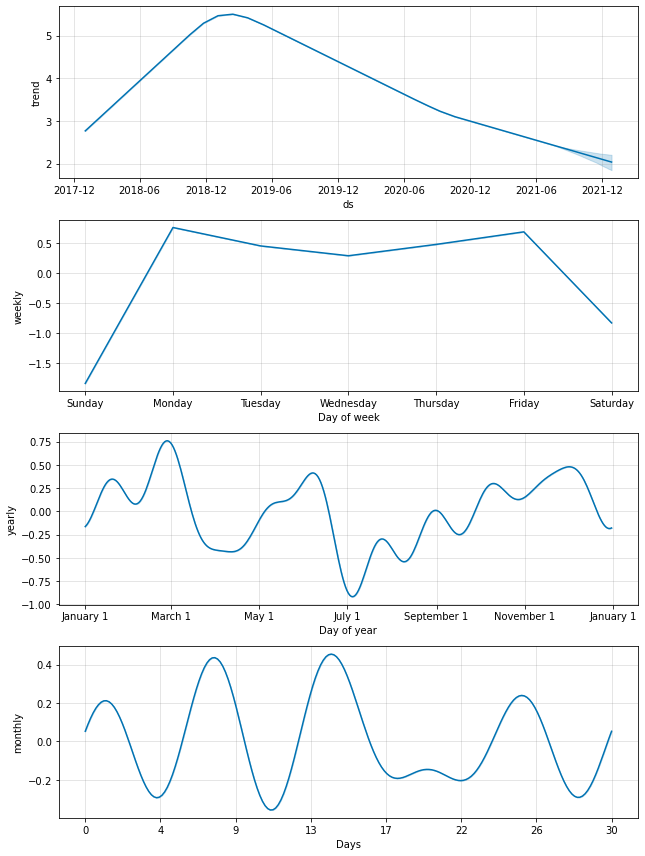

In [13]:
graficar_estacionalidad("ROBO A PASAJERO A BORDO DE TRANSPORTE PÚBLICO CON VIOLENCIA")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


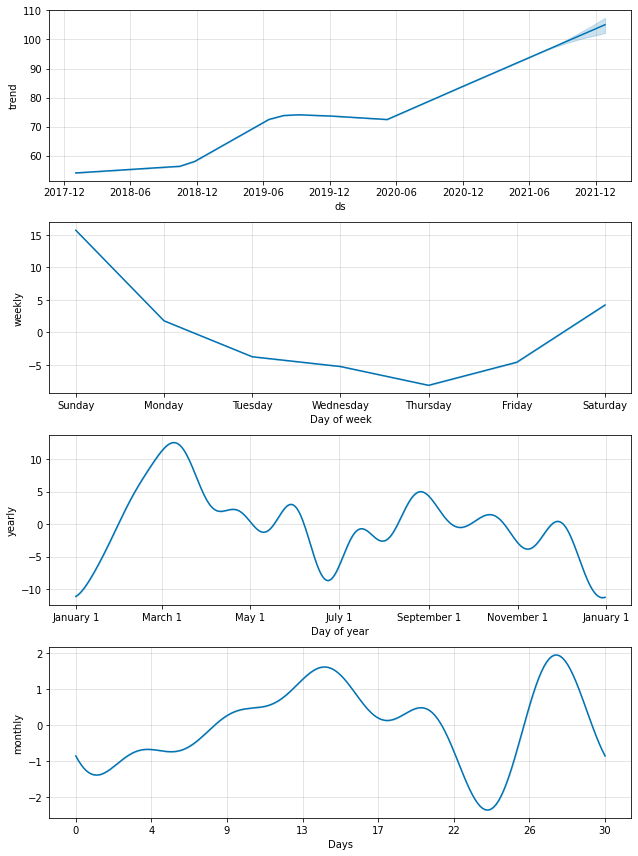

In [14]:
graficar_estacionalidad("VIOLENCIA FAMILIAR")

La estacionalidad del robo a pasajeros de transporte público nos muestra que existe una mayor cantidad de incidencias entre los días lunes y viernes, mientras que los fines de semana disminuyen. Una posible explicación de esto, es que entre semana hay un mayor uso del transporte público porque son los días que más gente sale a trabajar. La estacionalidad anual muestra una disminución durante julio que puede coincidir con el periodo vacacional de algunos trabajadores y estudiantes.

En cambio la estacionalidad semanal de la violencia familiar nos indica que la mayor cantidad de ocurrencias es durante los fines de semana, de hecho el día domingo hay aproximadamente 15 ocurrencias más del promedio. Esto se puede deber a que coincide con el día de descanso y toda la familia se encuentra en el hogar. También la estacionalidad mensual muestra un alza de los casos durante la quincena.

# 5. ¿Cuáles son los delitos que más caracterizan a cada alcaldía? Es decir, delitos que suceden con mayor frecuencia en una alcaldía y con menor frecuencia en las demás.

Para poder obtener el delito que más caracteriza a cada alcaldía lo calcularemos en terminos de la población de cada delegación. Primero calculamos la ocurrencia de los delitos por cada 100000 habitantes.

In [19]:
carpeta_ult_meses = carpeta_ult_meses[carpeta_ult_meses.alcaldia_hechos.isin(ALCALDIAS)]
df_alcaldia_delito = carpeta_ult_meses.groupby(['alcaldia_hechos','delito']).size()
df_alcaldia_delito = df_alcaldia_delito.reset_index()
df_alcaldia_delito = df_alcaldia_delito.rename(columns={0:"ocurrencias"})
df_alcaldia_delito = pd.merge(df_alcaldia_delito,poblacion_df, how='left', on="alcaldia_hechos")
df_alcaldia_delito["delito_por_cienmil"] = 100000*(df_alcaldia_delito["ocurrencias"]/df_alcaldia_delito["poblacion"])

In [20]:
def get_df_alcaldia(alcaldia):
    df_porcienmil= df_alcaldia_delito[df_alcaldia_delito.alcaldia_hechos==alcaldia]
    df_cienmil = df_porcienmil.sort_values(by="delito_por_cienmil",ascending = False).reset_index(drop=True).reset_index(drop=False)
    df_cienmil = df_cienmil.rename(columns={'index':'puntaje_delito'})
    return df_cienmil

Para encontrar el delito más representativo de cada delegación construimos la siguiente función, por delegación le asigna a cada delito un score de la siguiente forma:
- Le asigna la posición entre los delitos más comunes de la delegación
- Busca su posición entre los delitos en las demás delegaciones y le resta su ubicación

De esta forma buscamos al delito con el menor valor, pues será el que se encuentre más arriba en la alcaldía desea y más abajo en las demás. Nuevamente trabajaremos con los 50 delitos más comunes por delegación para evitar problemas con los delitos con poca información.

Calculando para todas las alcaldías tenemos la siguiente tabla.

In [21]:
def get_representativo_delito(alcaldia):
    df_alcaldia = get_df_alcaldia(alcaldia)
    df_alcaldia[:50]
    delitos_alcaldia = df_alcaldia.delito
    score_min = 0
    delito_rep = delitos_alcaldia.iloc[0]
    for delito_in in delitos_alcaldia:
        row_delito = df_alcaldia[df_alcaldia.delito == delito_in]
        score = row_delito["puntaje_delito"].iloc[0]
        copy_alcaldias = ALCALDIAS.copy()
        copy_alcaldias.remove(alcaldia)
        for otra_alcaldia in copy_alcaldias:
            df_otra_alcaldia = get_df_alcaldia(otra_alcaldia)
            delitos_otra_alcaldia = df_alcaldia.delito
            row_delito = df_alcaldia[df_alcaldia.delito == delito_in]
            try:
                score_otro = row_delito["puntaje_delito"].iloc[0]
            except:
                score_otro = -50
            score = -score_otro+score
        if score < score_min:
            score_min = score
            delito_rep = delito_in
    return delito_rep
            

In [22]:
## tarda unos 2 minutos porque hace los calculos para todas la delegaciones
delitos_representativos = []
for alcaldia in ALCALDIAS:
    delito = get_representativo_delito(alcaldia)
    delitos_representativos.append(delito)
    
df_delitos_rep = pd.DataFrame({'delegacion': ALCALDIAS, 'delito_representivo':delitos_representativos})

In [23]:
df_delitos_rep

,delegacion,delito_representivo
0,BENITO JUAREZ,ROBO A PASAJERO EN RTP SIN VIOLENCIA
1,IZTAPALAPA,PERDIDA DE LA VIDA POR PRECIPITACION
2,CUAUHTEMOC,PLAGIO O SECUESTRO
3,TLAHUAC,ROBO A PASAJERO EN TROLEBUS SIN VIOLENCIA
4,IZTACALCO,ABORTO
5,GUSTAVO A MADERO,"EXPLOTACIÓN LABORAL DE MENORES, PERSONAS CON D..."
6,MIGUEL HIDALGO,ROBO A TRANSEUNTE EN VIA PUBLICA (NOMINA) CON ...
7,TLALPAN,ABORTO
8,ALVARO OBREGON,LESIONES DOLOSAS POR QUEMADURAS
9,VENUSTIANO CARRANZA,ROBO DE CONTENEDORES DE TRAILERS S/V


# 6. Diseña un indicador que mida el nivel de “inseguridad”. Genéralo al nivel de desagregación que te parezca más adecuado (ej. manzana, calle, AGEB, etc.). Analiza los resultados ¿Encontraste algún patrón interesante? ¿Qué decisiones se podrían tomar con el indicador?


Vamos a integrar un conjunto de variables relacionadas con los delitos y la inseguridad y posteriormente las vamos a agregar en un único valor usando PCA. El nivel de desagregación va a ser a nivel delegación.

Para esto contaremos la cantidad de veces que ocurrieron los siguientes delitos:

- ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA
- ROBO A NEGOCIO CON VIOLENCIA
- ABUSO SEXUAL
- ROBO DE OBJETOS
- HOMICIDIO POR ARMA DE FUEGO

pues son algunos de los principales delitos relacionados con inseguridad. El algoritmo de PCA encontrara los coeficientes que determinan un índice para poder medir la inseguridad.




In [24]:
list_tran = []
list_neg = []
list_abus = []
list_robo = []
list_homi = []

for alcaldia in ALCALDIAS:
    df_alc = get_df_alcaldia(alcaldia)

    list_tran.append(df_alc[df_alc.delito == "ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA"].ocurrencias.iloc[0])
    list_neg.append(df_alc[df_alc.delito == "ROBO A NEGOCIO CON VIOLENCIA" ].ocurrencias.iloc[0])
    list_abus.append(df_alc[df_alc.delito == "ABUSO SEXUAL" ].ocurrencias.iloc[0])
    list_robo.append(df_alc[df_alc.delito == "ROBO DE OBJETOS" ].ocurrencias.iloc[0])
    list_homi.append(df_alc[df_alc.delito == "HOMICIDIO POR ARMA DE FUEGO" ].ocurrencias.iloc[0])

In [25]:
df_inseguridad = pd.DataFrame({'alcaldias':ALCALDIAS, 
                                "ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA":list_tran,
                                "ROBO A NEGOCIO CON VIOLENCIA":list_neg,
                                "ABUSO SEXUAL":list_abus,
                                "ROBO DE OBJETOS":list_robo,
                                "HOMICIDIO POR ARMA DE FUEGO":list_homi})
df_inseguridad = df_inseguridad.set_index('alcaldias')

In [26]:
## realizamos el PCA junto con un escalamiento de los datos
pca_pipe = make_pipeline( PCA())
pca_pipe.fit(df_inseguridad)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = df_inseguridad.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5']
)

,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ABUSO SEXUAL,ROBO DE OBJETOS,HOMICIDIO POR ARMA DE FUEGO
PC1,0.693473,0.167498,0.200646,0.668623,0.061028
PC2,-0.640316,-0.209628,-0.023379,0.732370,-0.095594
PC3,0.271661,-0.311073,-0.850821,0.080225,-0.314803
PC4,-0.177998,0.764064,-0.471360,0.099007,0.390565
PC5,-0.060060,0.497434,0.114533,-0.018414,-0.857610


Por lo tanto un índice para medir la inseguridad en una delegación se puede calcular con la fórmula de la primer componente principal

$$Indice =0.693473 * (\text{ROBOS A TRANSEUNTE}) +0.167498 	*(\text{ROBO A NEGOCIO})+0.200646 	*(\text{ABUSO SEXUAL})+ 0.668623 	*(\text{ROBO OBJETOS}) +0.06102*(\text{HOMICIDIO POR ARMA DE FUEGO}) 	  $$

Podemos notar que algunos de los delitos, como robos a transeunte y robo de objetos, tienen un mayor peso en los coeficientes del índice, pues son más frecuentes que otros, como abuso sexual y homicidio por arma de fuego.

Los resultados obtenidos con el índice estan relacionados con la tabla de ocurrencias de delitos totales.

Analizando otro conjunto de delitos y su peso, se puede tomar la decisión de a que delitos enfocarse en cada delegación pues algunos influiran más en el crecimiento del índice.

In [27]:
def calcular_indice(alcaldia):
    ocurrencias = df_inseguridad.loc[alcaldia]
    indice = ocurrencias["ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA"]*0.693473+ocurrencias["ROBO A NEGOCIO CON VIOLENCIA"]*0.167498+ocurrencias["ABUSO SEXUAL"]*0.200646+ocurrencias["ROBO DE OBJETOS"]*0.668623+ocurrencias["HOMICIDIO POR ARMA DE FUEGO"]*0.06102
    return indice

indices = []
for alcaldia in ALCALDIAS:
    indices.append(calcular_indice(alcaldia))
    
df_indices = pd.DataFrame({'alcaldias':ALCALDIAS,'indices':indices})
df_indices = df_indices.sort_values(by='indices',ascending=False)
df_indices = df_indices.reset_index(drop = True)
df_indices

,alcaldias,indices
0,IZTAPALAPA,2191.261629
1,CUAUHTEMOC,1948.459574
2,GUSTAVO A MADERO,1239.734611
3,MIGUEL HIDALGO,1142.324381
4,ALVARO OBREGON,1084.512948
5,COYOACAN,989.123597
6,BENITO JUAREZ,956.533822
7,VENUSTIANO CARRANZA,931.551873
8,TLALPAN,805.714941
9,AZCAPOTZALCO,696.626937


# Prueba caso BOPS

Primero limpiemos un poco la base de datos y obtengamos la información para los dos experimentos que nos interesan. Use excel para quitar el formato que tenian los datos numéricos.

Calcularemos las ganancias en USA del esquema B&M (Brick and Mortar) antes y después de la fecha de inicio programa BOPS y lo compararemos contra las ganancias obtenidas en los mismos intervalos de tiempo en Canadá, una región donde no se aplicó dicho programa, para comparar si de verdad se registraron perdidas en el esquema de ventas de B&M.

De la misma forma analizaremos las ganancias en el esquema de ventas online antes y después de la aplicación del programa BOPS, lo calcularemos en dos casos: ventas cercanas y ventas lejanas (en donde no se aplica el método BOPS pues tienen que pasar a recoger a una tienda cercana). 

In [28]:
## limpiamos la base de ventas BM
bops_bm = pd.read_csv('bops_bm.csv', parse_dates=[0])
bops_bm = bops_bm[['id (store)', 'year', 'month', 'week', 'after', 'usa', ' sales ']]
bops_bm = bops_bm.rename(columns = {' sales ':'sales'})
bops_bm = bops_bm.dropna()
## limpiamos la base de ventas online
bops_online = pd.read_csv('bops_online.csv', parse_dates=[0])
bops_online = bops_online[['id (DMA)', 'year', 'month', 'week', 'after', 'close', ' sales ']]
bops_online = bops_online.rename(columns = {' sales ':'sales'})
bops_online = bops_online.dropna()

In [29]:
## obtenemos las tablas del antes y después en Canadá (no se aplicó BOPS)
bm_canada = bops_bm[bops_bm.usa != 1]
bm_canada_before = bm_canada[bm_canada.after != 1]
bm_canada_after = bm_canada[bm_canada.after == 1]
## ventas totales antes y después del inicio de BOPS en Canada
ventas_canada_antes = sum(bm_canada_before.sales)
ventas_canada_despues = sum(bm_canada_after.sales)

## obtenemos las tablas del antes y después en USA (donde se aplicó BOPS)
bm_usa = bops_bm[bops_bm.usa == 1]
bm_usa_before = bm_usa[bm_usa.after != 1]
bm_usa_after = bm_usa[bm_usa.after == 1]
## ventas totales antes y después del inicio de BOPS en USA
ventas_usa_antes = sum(bm_usa_before.sales)
ventas_usa_despues = sum(bm_usa_after.sales)

In [30]:
ventas_canada = [ventas_canada_antes, ventas_canada_despues,ventas_canada_antes - ventas_canada_despues]
ventas_usa = [ventas_usa_antes, ventas_usa_despues, ventas_usa_antes-ventas_usa_despues]

In [31]:
## obtenemos las tablas del antes y después en ventas online lejanas
online_lejos = bops_online[bops_online.close != 1]
online_lejos_before = online_lejos[online_lejos.after != 1]
online_lejos_after = online_lejos[online_lejos.after == 1]
## ventas totales antes y después del inicio de BOPS en ventas online lejanas (sin BOPS)
ventas_online_lejos_antes = sum(online_lejos_before.sales)
ventas_online_lejos_despues = sum(online_lejos_after.sales)

## obtenemos las tablas del antes y después en ventas online cercanas
online_cerca = bops_online[bops_online.close == 1]
online_cerca_before = online_cerca[online_cerca.after != 1]
online_cerca_after = online_cerca[online_cerca.after == 1]
## ventas totales antes y después del inicio de BOPS en ventas online cercanas (con BOPS)
ventas_online_cerca_antes = sum(online_cerca_before.sales)
ventas_online_cerca_despues = sum(online_cerca_after.sales)

In [32]:
ventas_online_lejos = [ventas_online_lejos_antes, ventas_online_lejos_despues, ventas_online_lejos_antes-ventas_online_lejos_despues]
ventas_online_cerca = [ventas_online_cerca_antes, ventas_online_cerca_despues,ventas_online_cerca_antes-ventas_online_cerca_despues ]

In [33]:
tabla_ventas = pd.DataFrame({"BOPS":['antes','despues','diferencia'], "ventas_canada":ventas_canada,"ventas_usa": ventas_usa,
                            "ventas_online_lejos":ventas_online_lejos,"ventas_online_cerca":ventas_online_cerca})

In [34]:
tabla_ventas

,BOPS,ventas_canada,ventas_usa,ventas_online_lejos,ventas_online_cerca
0,antes,30689777.0,122730695.0,44378032.0,36090582.0
1,despues,25853285.0,110455609.0,37525951.0,29329034.0
2,diferencia,4836492.0,12275086.0,6852081.0,6761548.0


In [35]:
reduccion_online_cerca = 1-29329034.0/36090582.0
reduccion_online_lejos = 1-37525951.0/44378032.0
print(reduccion_online_cerca, reduccion_online_lejos)

0.18734937552406328 0.15440254313215152


In [36]:
reduccion_usa = 1-110455609.0/122730695.0 
reduccion_canada = 1-25853285.0/30689777.0
print(reduccion_usa, reduccion_canada)

0.10001643028257923 0.15759293395973517


In [37]:
perdidas_bops_online = 36090582*0.15440254313215152 - 6761548.0 
ganancias_bops_bm =  12275086.0 - 12275086.0*0.15759293395973517 

In [38]:
perdidas_bops_online

-1189070.3560805488

In [39]:
ganancias_bops_bm

10340619.18265193

In [40]:
ganancias_bops_bm + perdidas_bops_online

9151548.82657138

En las ventas online se tuvo un decrecimiento de las ventas muy parecido, en donde se aplicó BOPS se redujo en 6852081 y en donde no se aplicó BOPS 6761548, un decrecimiento del 18% y del 15% respectivamente, contra el periodo en que todavía no se usaba BOPS. Esto significa que BOPS registro perdidas en este esquema.

Otro caso es en el esquema de BM pues en USA, donde se aplicó BOPS, se tuvo una perdida de 12275086 y en Canadá, donde no se aplicó BOPS, se tuvo una perdida de 4836492, que representan una perdida del 10% y del 15% respectivamente. Esto significa que con BOPS se tuvieron menos perdidas.

Si en las ventas en línea no se hubiera usado el modelo BOPS y suponiendo que tendría un desempeño parecido a las ventas lejanas se tendría solo una perdida del 15%, en lugar de 18%, por lo que se perdieron en este caso 1189070 de dolares.

Por otro lado, en las ventas BM sin el modelo BOPS, y suponiendo que tendría un desempeño parecido a Canadá, se hubiera perdido el 15% en lugar del 10%, por lo que se tuvo una ganancia de 10340619.

Esto nos deja con una ganancia total para la empresa de 9151548 de dólares.

Algunos aspectos importantes de este caso son:
- Es probable que en ventas online se tuvo perdidas porque algunos clientes cambiaron a BOPS en BM.
- No fue muy correcto comparar los 6 meses antes del lanzamiento de BOPS contra los siguientes 6 meses después de dicho lanzamiento, pues durante el año ocurren muchos eventos que afectan la estacionalidad de las ventas y esto es uno de los factores que pudo provocar que se registraran perdidas en todos los escenarios. Lo más probable es que justo ese semestre sea el de ventas bajas en el año.